# <span style='color:maroon'>Using Clustering and Foursquare APIs to determine the optimal postal codes for ecommerce company to setup its offlines stores</span>

#### Choosing the city of Los Angeles as the seed city for this pilot for offline stores for ecommerce company
1) Get the set of postal codes for Los Angeles

2) For each postal code, get the list of recommended venues

3) Identify the optimal number of clusters for the postal codes

4) Plot the clusters using the optimal number of clusters and then analyse

5) Categorise the clusters based on the common themes relevant for getting the footfalls for offline stores

6) Recommend the best postal codes and clusters to setup its offline stores

In [155]:
# All Import statements

import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from bs4 import BeautifulSoup # library for parsing
import csv # library for reading from csv

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import matplotlib.pyplot as plt

# Please note that the terms Area and Zip are used interchangeably


### Define Foursquare Credentials and Version

In [ ]:
CLIENT_ID = 'P205TY3TP3W42QQDLYUFQ2ZUAVEKFHAI0O3VFNCFOV1EN1CR' # your Foursquare ID
CLIENT_SECRET = 'HNVKLNZOBKGHDDQJSEY11POTS0KXODDIMTHKIDFBL3ROVGI5' # your Foursquare Secret
VERSION = '20180604'

In [157]:
# Getting the file with the areas, postal codes and the latlong for the same
# The file with all the zip codes and lat-long was retieved from 'simple maps'

path=r'C:\Users\ah55406\Documents\Technical Reading\Data Science\Datascience with Python\Machine Learning\simplemaps_uszips_basicv1.5\uszips.xlsx'

df_latlong=pd.read_excel(path)


In [158]:
# Getting the rows for only
df=df_latlong[df_latlong['city'] == 'Los Angeles']

df.shape

(65, 16)

In [159]:
df=df.iloc[:,[0,1,2,9]]
df = df.reset_index(drop=True)
df

,zip,lat,lng,density
0,90001,33.9740,-118.2495,6295.9
1,90002,33.9491,-118.2467,6458.8
2,90003,33.9641,-118.2737,7204.7
3,90004,34.0762,-118.3108,7876.3
4,90005,34.0591,-118.3064,13421.3
5,90006,34.0480,-118.2942,11903.1
6,90007,34.0281,-118.2849,6403.9
7,90008,34.0096,-118.3471,3398.1
8,90010,34.0621,-118.3162,3208.3
9,90011,34.0071,-118.2587,9359.3


### Getting Venues around each area

In [160]:
LIMIT=200 # defines the number of venues for each postal codes

In [161]:
# Defining the function that gets venue for each area

def getNearbyVenues(areas, latitudes, longitudes, density,radius):
    
    venues_list=[]
    for area, lat, lng, density in zip(areas, latitudes, longitudes, density ):
        print(area)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            area, 
            lat, 
            lng, 
            density,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    print(venues_list)
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                             'Density',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [162]:
# Getting the venues near each zipcode
city_venues = getNearbyVenues(areas=df['zip'],
                                   latitudes=df['lat'],
                                   longitudes=df['lng'],
                                   density=df['density'],
                                   radius=500,
                                  )

90001
90002
90003
90004
90005
90006
90007
90008
90010
90011
90012
90013
90014
90015
90016
90017
90018
90019
90020
90021
90022
90023
90024
90025
90026
90027
90028
90029
90031
90032
90033
90034
90035
90036
90037
90038
90039
90040
90041
90042
90043
90044
90045
90046
90047
90048
90049
90056
90057
90058
90059
90061
90062
90063
90064
90065
90066
90067
90068
90071
90073
90077
90079
90089
90095
[[(90001, 33.974, -118.2495, 6295.9, 'Superior Grocers', 33.97328043615116, -118.24707865857803, 'Grocery Store'), (90001, 33.974, -118.2495, 6295.9, 'Rite Aid', 33.9743831, -118.2463507, 'Pharmacy'), (90001, 33.974, -118.2495, 6295.9, 'Jack in the Box', 33.97516673734529, -118.25031280517578, 'Fast Food Restaurant'), (90001, 33.974, -118.2495, 6295.9, 'SUBWAY', 33.975310921669006, -118.24803829193115, 'Sandwich Place'), (90001, 33.974, -118.2495, 6295.9, "Bill's Drive In", 33.974500448421715, -118.24422506707806, 'Burger Joint'), (90001, 33.974, -118.2495, 6295.9, 'Pizza Hut', 33.975157840137115, -118.

In [203]:
#Checking the size of the dataframe of venues
print(city_venues.shape)

(1592, 8)


In [204]:
# Checking the rows in the data frame created
city_venues
# Please note that the terms Area and Zip are used interchangeably

,Area,Area Latitude,Area Longitude,Density,Venue,Venue Latitude,Venue Longitude,Venue Category
0,90001,33.9740,-118.2495,6295.9,Superior Grocers,33.973280,-118.247079,Grocery Store
1,90001,33.9740,-118.2495,6295.9,Rite Aid,33.974383,-118.246351,Pharmacy
2,90001,33.9740,-118.2495,6295.9,Jack in the Box,33.975167,-118.250313,Fast Food Restaurant
3,90001,33.9740,-118.2495,6295.9,SUBWAY,33.975311,-118.248038,Sandwich Place
4,90001,33.9740,-118.2495,6295.9,Bill's Drive In,33.974500,-118.244225,Burger Joint
5,90001,33.9740,-118.2495,6295.9,Pizza Hut,33.975158,-118.248129,Pizza Place
6,90001,33.9740,-118.2495,6295.9,WINCHELL'S DONUT HOUSE,33.975075,-118.248211,Donut Shop
7,90001,33.9740,-118.2495,6295.9,Amapola,33.974076,-118.248034,Fruit & Vegetable Store
8,90001,33.9740,-118.2495,6295.9,WSS,33.974881,-118.247646,Shoe Store
9,90001,33.9740,-118.2495,6295.9,El Senor Taco,33.974962,-118.246924,Mexican Restaurant


In [205]:
# Observing the data by getting a count of  all venues for the Area

city_venues_category_grouped=city_venues.groupby('Area')[['Venue Category']].count()

city_venues_category_grouped

,Venue Category
Area,
90001,10
90002,1
90003,4
90004,54
90005,34
90006,13
90007,19
90008,2
90010,23


#### We see that many of the zip codes have less than 10 recommended venues. Lets identify them better

In [206]:
city_venues_category_grouped.sort_values(by='Venue Category',inplace=True, ascending=False)

In [207]:
# Forming a new data frame containing Zip Codes/Areas with more than 10 venues only
new_zipcodes=city_venues_category_grouped[city_venues_category_grouped['Venue Category']>=10]
new_zipcodes.size

39

#### Lets consider only these 39 zip codes for our analysis. We are assuming that zipcodes with less than 10 recommended venues may not have enough footfalls worthy of setting up offline stores

In [208]:
new_zipcodes

,Venue Category
Area,
90071,100
90028,100
90014,100
90048,98
90013,88
90067,74
90079,64
90066,59
90004,54


In [209]:
# Getting the revised City_venues dataframe with the shortlisted zip codes and related places only
newzipcodelist=new_zipcodes.index.tolist()
newzipcodelist

[90071,
 90028,
 90014,
 90048,
 90013,
 90067,
 90079,
 90066,
 90004,
 90015,
 90026,
 90095,
 90035,
 90020,
 90017,
 90064,
 90041,
 90005,
 90019,
 90089,
 90012,
 90025,
 90057,
 90042,
 90038,
 90010,
 90029,
 90007,
 90043,
 90045,
 90006,
 90037,
 90023,
 90011,
 90001,
 90016,
 90034,
 90021,
 90022]

In [210]:
new_city_venues=city_venues[city_venues.Area.isin(newzipcodelist)]
new_city_venues.Area.unique().size # Confirms all the zipcodes are taken

39

In [211]:
# Let's find out how many unique categories can be curated from all the returned venues
print('There are {} unique categories.'.format(len(new_city_venues['Venue Category'].unique())))

There are 240 unique categories.


### Algorithm decision point
#### We see that the zip codes and areas have categories( upto 240 types). These categories range from food joints, 
#### entertainment centres, shopping centres, health/fitness areas, etc

#### As we do not have a definite pattern of categories, we can attempt a unsupervised algorithm that can help us form clusters and then we can use them to further analyse the set of zipcodes suited for offline stores. We will use a k-means clustering algorithm

#### For using a clustering algorithm, we need to first convert the venues into a series of categorical features

### Preprocessing the data frame for categorical data

In [212]:
# one hot encoding
city_onehot = pd.get_dummies(new_city_venues[['Venue Category']], prefix="", prefix_sep="")

# add Area column back to dataframe
city_onehot['Area'] = new_city_venues['Area'] 

# move neighborhood column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head()

,Area,ATM,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [213]:
# Build new df with the revised order of columns
city_onehot = city_onehot[fixed_columns]

city_onehot.head(20)

,Area,ATM,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
#Looking at the data for one of the zipcodes
city_onehot[city_onehot['Area']==90001]

,Area,ATM,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,90001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [214]:
# Getting a new data frame with venues aggregated by Zipcode
city_grouped = city_onehot.groupby('Area').mean().reset_index()
city_grouped.head(10)

,Area,ATM,Accessories Store,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,90001,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000
1,90004,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.018519,0.0,0.0,0.00,0.0,0.0,0.000000
2,90005,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.029412
3,90006,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.076923,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000
4,90007,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.052632
5,90010,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.043478,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000
6,90011,0.0,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000
7,90012,0.0,0.0,0.00,0.000000,0.037037,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.074074,0.0,0.0,0.00,0.0,0.0,0.000000
8,90013,0.0,0.0,0.00,0.011364,0.022727,0.0,0.022727,0.000000,0.0,...,0.011364,0.000000,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000
9,90014,0.0,0.0,0.02,0.000000,0.000000,0.0,0.010000,0.010000,0.0,...,0.010000,0.000000,0.0,0.000000,0.0,0.0,0.02,0.0,0.0,0.020000


In [215]:
city_grouped.shape

(39, 241)

In [216]:
# Checking the categories ...
column_headers=city_grouped.columns
for header in column_headers:
    print (header)

Area
ATM
Accessories Store
American Restaurant
Arcade
Art Gallery
Art Museum
Arts & Crafts Store
Asian Restaurant
Athletics & Sports
Automotive Shop
BBQ Joint
Bakery
Bank
Bar
Basketball Court
Basketball Stadium
Bed & Breakfast
Beer Bar
Beer Garden
Beer Store
Big Box Store
Board Shop
Bookstore
Boutique
Bowling Alley
Brazilian Restaurant
Breakfast Spot
Brewery
Bridal Shop
Bubble Tea Shop
Building
Burger Joint
Burrito Place
Bus Station
Cafeteria
Café
Cajun / Creole Restaurant
Cantonese Restaurant
Caribbean Restaurant
Check Cashing Service
Chinese Restaurant
Clothing Store
Cocktail Bar
Coffee Shop
College Academic Building
College Administrative Building
College Arts Building
College Bookstore
College Cafeteria
College Rec Center
College Residence Hall
Comedy Club
Comic Shop
Concert Hall
Construction & Landscaping
Convenience Store
Cosmetics Shop
Coworking Space
Creperie
Cycle Studio
Dance Studio
Deli / Bodega
Department Store
Dessert Shop
Dim Sum Restaurant
Diner
Discount Store
Dive Bar
D

# Let's print each area along with the top 10 most common venues

In [217]:
num_top_venues = 10

for area in city_grouped['Area']:
    print(area)
    temp = city_grouped[city_grouped['Area'] == area].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    #temp = temp.round({'freq': 30})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

90001
                     venue  freq
0             Burger Joint   0.1
1           Sandwich Place   0.1
2  Fruit & Vegetable Store   0.1
3              Pizza Place   0.1
4            Grocery Store   0.1
5     Fast Food Restaurant   0.1
6                 Pharmacy   0.1
7               Donut Shop   0.1
8               Shoe Store   0.1
9       Mexican Restaurant   0.1


90004
                 venue      freq
0    Korean Restaurant  0.203704
1          Coffee Shop  0.055556
2                  Bar  0.055556
3               Bakery  0.055556
4   Seafood Restaurant  0.037037
5  Japanese Restaurant  0.037037
6          Bridal Shop  0.037037
7         Cocktail Bar  0.037037
8       Sandwich Place  0.037037
9         Noodle House  0.018519


90005
                 venue      freq
0    Korean Restaurant  0.411765
1  Japanese Restaurant  0.058824
2          Coffee Shop  0.058824
3                 Café  0.058824
4          Yoga Studio  0.029412
5             Beer Bar  0.029412
6       Ice Cream Sho

                   venue      freq
0                    Gym  0.086957
1                  Hotel  0.086957
2  General Entertainment  0.043478
3   Fast Food Restaurant  0.043478
4                  Motel  0.043478
5            Coffee Shop  0.043478
6          Burrito Place  0.043478
7             Non-Profit  0.043478
8            Supermarket  0.043478
9             Taco Place  0.043478


90041
                venue      freq
0           Pet Store  0.055556
1  Italian Restaurant  0.055556
2    Asian Restaurant  0.055556
3   French Restaurant  0.055556
4  Chinese Restaurant  0.027778
5          Board Shop  0.027778
6          Theme Park  0.027778
7            Boutique  0.027778
8   Convenience Store  0.027778
9     Thai Restaurant  0.027778


90042
                  venue      freq
0           Pizza Place  0.125000
1    Italian Restaurant  0.083333
2  Fast Food Restaurant  0.083333
3                   Bar  0.041667
4            Taco Place  0.041667
5    Mexican Restaurant  0.041667
6        

In [218]:
#Let's put that into a pandas dataframe

#First, let's write a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [219]:
# Display top 10
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
city_neighborhoods_venues_sorted['Area'] = city_grouped['Area']

for ind in np.arange(city_grouped.shape[0]):
    city_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

city_neighborhoods_venues_sorted

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,90001,Pizza Place,Donut Shop,Mexican Restaurant,Fruit & Vegetable Store,Shoe Store,Fast Food Restaurant,Grocery Store,Sandwich Place,Burger Joint,Pharmacy
1,90004,Korean Restaurant,Bakery,Bar,Coffee Shop,Seafood Restaurant,Sandwich Place,Cocktail Bar,Bridal Shop,Japanese Restaurant,Mattress Store
2,90005,Korean Restaurant,Café,Japanese Restaurant,Coffee Shop,Yoga Studio,Steakhouse,Gift Shop,Noodle House,Beer Bar,Concert Hall
3,90006,Donut Shop,Ice Cream Shop,Video Game Store,Pizza Place,Bus Station,Food Truck,Sandwich Place,Latin American Restaurant,Grocery Store,Spa
4,90007,Coffee Shop,Shipping Store,Yoga Studio,College Residence Hall,Caribbean Restaurant,Food Truck,Mediterranean Restaurant,Gastropub,Big Box Store,Farmers Market
5,90010,Korean Restaurant,Coffee Shop,Japanese Restaurant,Pizza Place,Construction & Landscaping,Tea Room,Martial Arts Dojo,Fast Food Restaurant,Convenience Store,Asian Restaurant
6,90011,Fast Food Restaurant,Mexican Restaurant,Ice Cream Shop,Pizza Place,Fried Chicken Joint,Discount Store,Donut Shop,Park,Food,Flea Market
7,90012,Chinese Restaurant,Bakery,Bar,Vietnamese Restaurant,Monument / Landmark,Café,Brewery,Recreation Center,Bubble Tea Shop,Burger Joint
8,90013,Japanese Restaurant,Sushi Restaurant,Ice Cream Shop,Ramen Restaurant,Gift Shop,Brewery,Cocktail Bar,Coffee Shop,Bakery,Bubble Tea Shop
9,90014,Bar,Coffee Shop,Burger Joint,Music Venue,Hotel,Italian Restaurant,Theater,Yoga Studio,Juice Bar,Café


### Now that we have the areas arranged by categories, let us run a clustering algorithm to determine the clusters


## Cluster Areas

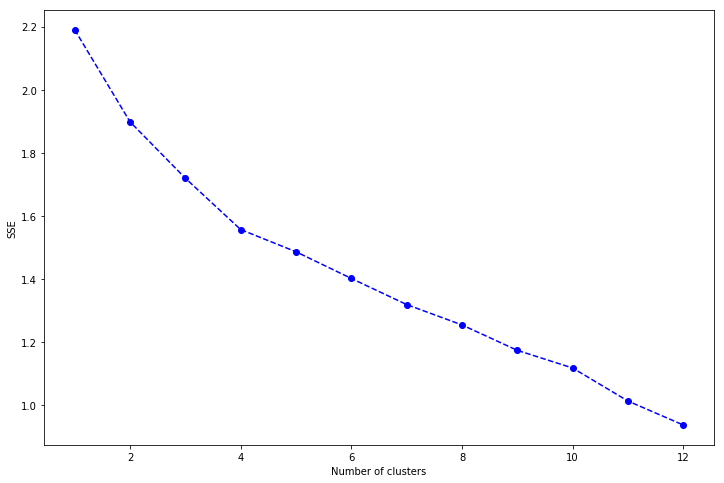

In [220]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# Using the Elbow method to find the optimal k

# set number of clusters
maxkclusters = 12
sse=[]

city_grouped_clustering = city_grouped.drop('Area', 1)

for k in range(1,maxkclusters+1):
    
    # run k-means clustering
    kmeans = KMeans(init='k-means++',n_clusters=k, random_state=1).fit(city_grouped_clustering)
    sse.append(kmeans.inertia_)
   
    
plt.figure(figsize=(12,8))
plt.plot(range(1,maxkclusters+1), sse,'--bo')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()


#### As we see above, the elbow of the curve is at 4, so the optimum number of clusters is 4

In [221]:
# set number of clusters
kclusters = 4

city_grouped_clustering = city_grouped.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(init='k-means++',n_clusters=kclusters, random_state=5).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 3, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [222]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each postal code

# add clustering labels
city_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
city_neighborhoods_venues_sorted

,Cluster Labels,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,90001,Pizza Place,Donut Shop,Mexican Restaurant,Fruit & Vegetable Store,Shoe Store,Fast Food Restaurant,Grocery Store,Sandwich Place,Burger Joint,Pharmacy
1,1,90004,Korean Restaurant,Bakery,Bar,Coffee Shop,Seafood Restaurant,Sandwich Place,Cocktail Bar,Bridal Shop,Japanese Restaurant,Mattress Store
2,1,90005,Korean Restaurant,Café,Japanese Restaurant,Coffee Shop,Yoga Studio,Steakhouse,Gift Shop,Noodle House,Beer Bar,Concert Hall
3,0,90006,Donut Shop,Ice Cream Shop,Video Game Store,Pizza Place,Bus Station,Food Truck,Sandwich Place,Latin American Restaurant,Grocery Store,Spa
4,0,90007,Coffee Shop,Shipping Store,Yoga Studio,College Residence Hall,Caribbean Restaurant,Food Truck,Mediterranean Restaurant,Gastropub,Big Box Store,Farmers Market
5,1,90010,Korean Restaurant,Coffee Shop,Japanese Restaurant,Pizza Place,Construction & Landscaping,Tea Room,Martial Arts Dojo,Fast Food Restaurant,Convenience Store,Asian Restaurant
6,0,90011,Fast Food Restaurant,Mexican Restaurant,Ice Cream Shop,Pizza Place,Fried Chicken Joint,Discount Store,Donut Shop,Park,Food,Flea Market
7,2,90012,Chinese Restaurant,Bakery,Bar,Vietnamese Restaurant,Monument / Landmark,Café,Brewery,Recreation Center,Bubble Tea Shop,Burger Joint
8,0,90013,Japanese Restaurant,Sushi Restaurant,Ice Cream Shop,Ramen Restaurant,Gift Shop,Brewery,Cocktail Bar,Coffee Shop,Bakery,Bubble Tea Shop
9,0,90014,Bar,Coffee Shop,Burger Joint,Music Venue,Hotel,Italian Restaurant,Theater,Yoga Studio,Juice Bar,Café


In [232]:
# Merge the df containing zip,lat,long and this df to add latitude/longitude for each area

# As the zip is a string and Area is a int, we need to convert zipcode to an int first and then merge
df_new=df
df_new['zip']=df_new['zip'].astype(int)
df_new

,zip,lat,lng,density
0,90001,33.9740,-118.2495,6295.9
1,90002,33.9491,-118.2467,6458.8
2,90003,33.9641,-118.2737,7204.7
3,90004,34.0762,-118.3108,7876.3
4,90005,34.0591,-118.3064,13421.3
5,90006,34.0480,-118.2942,11903.1
6,90007,34.0281,-118.2849,6403.9
7,90008,34.0096,-118.3471,3398.1
8,90010,34.0621,-118.3162,3208.3
9,90011,34.0071,-118.2587,9359.3


In [233]:
# Merging the dataframes to get a consolidated view
city_merged = pd.merge(df_new,city_neighborhoods_venues_sorted, left_on='zip', right_on='Area')

#city_merged.sort_values("Cluster Labels", inplace=True)

city_merged

,zip,lat,lng,density,Cluster Labels,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,90001,33.9740,-118.2495,6295.9,0,90001,Pizza Place,Donut Shop,Mexican Restaurant,Fruit & Vegetable Store,Shoe Store,Fast Food Restaurant,Grocery Store,Sandwich Place,Burger Joint,Pharmacy
1,90004,34.0762,-118.3108,7876.3,1,90004,Korean Restaurant,Bakery,Bar,Coffee Shop,Seafood Restaurant,Sandwich Place,Cocktail Bar,Bridal Shop,Japanese Restaurant,Mattress Store
2,90005,34.0591,-118.3064,13421.3,1,90005,Korean Restaurant,Café,Japanese Restaurant,Coffee Shop,Yoga Studio,Steakhouse,Gift Shop,Noodle House,Beer Bar,Concert Hall
3,90006,34.0480,-118.2942,11903.1,0,90006,Donut Shop,Ice Cream Shop,Video Game Store,Pizza Place,Bus Station,Food Truck,Sandwich Place,Latin American Restaurant,Grocery Store,Spa
4,90007,34.0281,-118.2849,6403.9,0,90007,Coffee Shop,Shipping Store,Yoga Studio,College Residence Hall,Caribbean Restaurant,Food Truck,Mediterranean Restaurant,Gastropub,Big Box Store,Farmers Market
5,90010,34.0621,-118.3162,3208.3,1,90010,Korean Restaurant,Coffee Shop,Japanese Restaurant,Pizza Place,Construction & Landscaping,Tea Room,Martial Arts Dojo,Fast Food Restaurant,Convenience Store,Asian Restaurant
6,90011,34.0071,-118.2587,9359.3,0,90011,Fast Food Restaurant,Mexican Restaurant,Ice Cream Shop,Pizza Place,Fried Chicken Joint,Discount Store,Donut Shop,Park,Food,Flea Market
7,90012,34.0660,-118.2382,3711.6,2,90012,Chinese Restaurant,Bakery,Bar,Vietnamese Restaurant,Monument / Landmark,Café,Brewery,Recreation Center,Bubble Tea Shop,Burger Joint
8,90013,34.0448,-118.2403,6774.5,0,90013,Japanese Restaurant,Sushi Restaurant,Ice Cream Shop,Ramen Restaurant,Gift Shop,Brewery,Cocktail Bar,Coffee Shop,Bakery,Bubble Tea Shop
9,90014,34.0431,-118.2517,9550.9,0,90014,Bar,Coffee Shop,Burger Joint,Music Venue,Hotel,Italian Restaurant,Theater,Yoga Studio,Juice Bar,Café


#### Now that we have our clusters, we need to consider an additonal point which is the population density of the cluster
#### A cluster is formed of zipcodes that are similar in nature based on the venue categories. However, the population density of the cluster will determine the number of footfalls in that cluster
#### More the footfalls, better is the suitability of the zipcode/area for the offline store

### Let us first plot the map using the population density and then plot the zip codes on it based on the clusters

## Mapping

#### Choropleth Map
We will first plot the choropleth map as per the population density of each zip code.

#### Markers based on clusters
We will then overlay the cluster popups on the map to signify the clustered zip codes.

Based on the clusters and population density, we can get a fair idea of the trending venues and the likely footfalls in these postal codes

In [234]:
# Choropleth Map

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# LatLong for Los Angeles

address = 'Los Angeles, CA'

# geolocator = Nominatim(user_agent="toronto_explorer")

# location = geolocator.geocode(address)

# Service timed out after multiple tries, so inserting lat-long values directly
latitude =  34.0522 #location.latitude
longitude =  -118.2437 #location.longitude

# the Zip codes in the Geojson are strings, so converting the zip codes in our dataframe to strings
df['zip'] = df['zip'].astype('int').astype('str')


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10,tiles="OpenStreetMap")


# generate choropleth map using the geojson data 
# Geojson data retrieved from https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/ca_california_zip_codes_geo.min.json
# Pruned the data to LA specific zip codes only

la_geo=r"C:\Users\ah55406\Documents\Technical Reading\Data Science\Datascience with Python\Machine Learning\LA-zipcodes.geojson"

map_clusters.choropleth(
    geo_data=la_geo,
    data=df,
    columns=['zip', 'density'],
    key_on='feature.properties.external_id',
    fill_color='YlOrRd', 
    fill_opacity='0.7',
    line_opacity='0.2',
    legend_name='Population density'
)

folium.LayerControl().add_to(map_clusters)
# display map
map_clusters

In [235]:
# Plotting the zip codes as per the clusters

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, density in zip(city_merged['lat'], city_merged['lng'], \
                                           city_merged['zip'], city_merged['Cluster Labels'], city_merged['density']):
    label = folium.Popup(str(poi) + '\n Cluster ' + str(cluster) + '\nDensity: ' + str(density), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1.5).add_to(map_clusters)

    
# display map
map_clusters

### Observations

#### We see that the within a cluster, some postal codes are in very high density area which would suit better the footfall probability for an offline store. As an example, the 90057 in Cluster 0 is in the most dense area and so within Cluster 0, the chances of footfalls for 90057 are much higher than say 90045 which has much lesser density

### Looking at each cluster

### Cluster 0

In [236]:
# Looking at cluster 0
city_merged[city_merged['Cluster Labels']==0]

,zip,lat,lng,density,Cluster Labels,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,90001,33.9740,-118.2495,6295.9,0,90001,Pizza Place,Donut Shop,Mexican Restaurant,Fruit & Vegetable Store,Shoe Store,Fast Food Restaurant,Grocery Store,Sandwich Place,Burger Joint,Pharmacy
3,90006,34.0480,-118.2942,11903.1,0,90006,Donut Shop,Ice Cream Shop,Video Game Store,Pizza Place,Bus Station,Food Truck,Sandwich Place,Latin American Restaurant,Grocery Store,Spa
4,90007,34.0281,-118.2849,6403.9,0,90007,Coffee Shop,Shipping Store,Yoga Studio,College Residence Hall,Caribbean Restaurant,Food Truck,Mediterranean Restaurant,Gastropub,Big Box Store,Farmers Market
6,90011,34.0071,-118.2587,9359.3,0,90011,Fast Food Restaurant,Mexican Restaurant,Ice Cream Shop,Pizza Place,Fried Chicken Joint,Discount Store,Donut Shop,Park,Food,Flea Market
8,90013,34.0448,-118.2403,6774.5,0,90013,Japanese Restaurant,Sushi Restaurant,Ice Cream Shop,Ramen Restaurant,Gift Shop,Brewery,Cocktail Bar,Coffee Shop,Bakery,Bubble Tea Shop
9,90014,34.0431,-118.2517,9550.9,0,90014,Bar,Coffee Shop,Burger Joint,Music Venue,Hotel,Italian Restaurant,Theater,Yoga Studio,Juice Bar,Café
10,90015,34.0394,-118.2664,4285.4,0,90015,Food Truck,Coffee Shop,Bar,Sports Bar,Mexican Restaurant,Breakfast Spot,Bubble Tea Shop,Snack Place,Office,Smoke Shop
11,90016,34.0287,-118.3546,5066.6,0,90016,Mexican Restaurant,Latin American Restaurant,Performing Arts Venue,Park,Sandwich Place,Check Cashing Service,Food,Fried Chicken Joint,Deli / Bodega,Wine Bar
12,90017,34.0529,-118.2643,12635.3,0,90017,Coffee Shop,Clothing Store,Café,Sandwich Place,Gym,Motel,Mexican Restaurant,Steakhouse,Thai Restaurant,Food Truck
13,90019,34.0486,-118.3387,6401.0,0,90019,Furniture / Home Store,Bank,Sandwich Place,Pizza Place,Chinese Restaurant,Burger Joint,Shopping Mall,Mexican Restaurant,Shipping Store,Mobile Phone Shop


In [237]:
df_cl0=city_merged[city_merged['Cluster Labels']==0]

arealist=df_cl0.Area.tolist()

df_cl0=city_venues[city_venues.Area.isin(arealist)]

df_cl0['Venue Category'].value_counts()

Coffee Shop                        62
Mexican Restaurant                 45
Café                               37
Pizza Place                        35
Sandwich Place                     33
Bar                                33
Clothing Store                     31
Food Truck                         30
Hotel                              25
Italian Restaurant                 24
Bakery                             23
Burger Joint                       22
Japanese Restaurant                21
American Restaurant                20
Grocery Store                      19
Fast Food Restaurant               19
Sushi Restaurant                   17
Gym                                16
Juice Bar                          14
Ice Cream Shop                     14
Music Venue                        13
Pharmacy                           13
Convenience Store                  13
Donut Shop                         13
French Restaurant                  12
Gym / Fitness Center               12
Gastropub   

 __Cluster 0__ appears to have a good mix of fast food places, cafes, restaurants and shopping areas. Withing Cluster 0, the zip codes with high population density are more suited for higher footfalls and therefore the target areas of offline stores

#### Top 5 Zipcodes based on Population Density are 90006, 90017, 90029, 90057, 90014


### Cluster 1

In [238]:
city_merged[city_merged['Cluster Labels']==1]

,zip,lat,lng,density,Cluster Labels,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,90004,34.0762,-118.3108,7876.3,1,90004,Korean Restaurant,Bakery,Bar,Coffee Shop,Seafood Restaurant,Sandwich Place,Cocktail Bar,Bridal Shop,Japanese Restaurant,Mattress Store
2,90005,34.0591,-118.3064,13421.3,1,90005,Korean Restaurant,Café,Japanese Restaurant,Coffee Shop,Yoga Studio,Steakhouse,Gift Shop,Noodle House,Beer Bar,Concert Hall
5,90010,34.0621,-118.3162,3208.3,1,90010,Korean Restaurant,Coffee Shop,Japanese Restaurant,Pizza Place,Construction & Landscaping,Tea Room,Martial Arts Dojo,Fast Food Restaurant,Convenience Store,Asian Restaurant
14,90020,34.0664,-118.3099,13310.8,1,90020,Korean Restaurant,Café,Dessert Shop,Ice Cream Shop,Bakery,Asian Restaurant,Shopping Mall,Coffee Shop,Diner,Burger Joint


In [240]:
df_cl1=city_merged[city_merged['Cluster Labels']==1]

arealist=df_cl1.Area.tolist()

df_cl1=city_venues[city_venues.Area.isin(arealist)]

df_cl1['Venue Category'].value_counts()

Korean Restaurant             39
Coffee Shop                   10
Japanese Restaurant            7
Café                           7
Bakery                         6
Bar                            4
Ice Cream Shop                 3
Sandwich Place                 3
Dessert Shop                   3
Convenience Store              3
Asian Restaurant               3
Juice Bar                      2
Bridal Shop                    2
Sushi Restaurant               2
Diner                          2
Seafood Restaurant             2
Cocktail Bar                   2
Noodle House                   2
BBQ Joint                      2
Pizza Place                    2
Brazilian Restaurant           2
Italian Restaurant             1
Grocery Store                  1
Burger Joint                   1
Beer Garden                    1
Gift Shop                      1
Shoe Repair                    1
Salon / Barbershop             1
Beer Bar                       1
South American Restaurant      1
          



__Cluster 1__ appears to concentrated around restaurants with few instances of other categories like shops, fitness centres etc. Also, cluster 1 is in relatively high dense areas of the city. With these two conditions, the __entire cluster__ is likely to get high percentage of footfalls throughout the day


### Cluster 2

In [241]:
city_merged[city_merged['Cluster Labels']==2]

,zip,lat,lng,density,Cluster Labels,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,90012,34.066,-118.2382,3711.6,2,90012,Chinese Restaurant,Bakery,Bar,Vietnamese Restaurant,Monument / Landmark,Café,Brewery,Recreation Center,Bubble Tea Shop,Burger Joint


In [242]:
df_cl2=city_merged[city_merged['Cluster Labels']==2]

arealist=df_cl2.Area.tolist()

df_cl2=city_venues[city_venues.Area.isin(arealist)]

df_cl2['Venue Category'].value_counts()

Chinese Restaurant       9
Bakery                   3
Vietnamese Restaurant    2
Bar                      2
Recreation Center        1
Burger Joint             1
Art Gallery              1
Café                     1
Brewery                  1
Diner                    1
Jazz Club                1
French Restaurant        1
Plaza                    1
Bubble Tea Shop          1
Monument / Landmark      1
Name: Venue Category, dtype: int64

__Cluster 2__ is only zip code with predominantly Asian Restaurants in it. Also, it has an Art Gallery, Jazz Club and Recreation Center in it. As it is a single zip code cluster and has venues which have infrequent footfalls( higher footfalls on weekends or weekday evenings), it will be have lower chances( as compared to Cluster 0 top 5 and Cluster 1) for offline stores 

### Cluster 3

In [243]:
city_merged[city_merged['Cluster Labels']==3]

,zip,lat,lng,density,Cluster Labels,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,90022,34.0245,-118.1561,5919.8,3,90022,Mexican Restaurant,Pizza Place,Donut Shop,Food Truck,Shoe Store,Bank,Mobile Phone Shop,Convenience Store,Discount Store,Flea Market
17,90023,34.0228,-118.1999,4195.7,3,90023,Mexican Restaurant,Pizza Place,Video Game Store,Food Truck,Seafood Restaurant,Sandwich Place,Discount Store,Grocery Store,Department Store,Dessert Shop


In [244]:
df_cl3=city_merged[city_merged['Cluster Labels']==3]

arealist=df_cl3.Area.tolist()

df_cl3=city_venues[city_venues.Area.isin(arealist)]

df_cl3['Venue Category'].value_counts()

Mexican Restaurant    5
Pizza Place           2
Food Truck            2
Mobile Phone Shop     1
Department Store      1
Discount Store        1
Convenience Store     1
Donut Shop            1
Bank                  1
Sandwich Place        1
Dessert Shop          1
Video Game Store      1
Shoe Store            1
Grocery Store         1
Seafood Restaurant    1
Name: Venue Category, dtype: int64

__Cluster 3__ is only zip code with predominantly Mexican Restaurants in it. It has low population density as well 

## <span style='color:maroon'>Summary</span>

Based on the above analysis, we can suggest the ecommerce company to setup the offline stores in the below order of priority

The ecommerce store may choose to launch only a handful offline stores in each of the priority areas or only in the highest priority areas. 

#### Priority 1
Cluster 0 - top 5 zip codes and Cluster 1 - are both concentrated in relatively high population density and with a balanced mix of food joints, shopping centres, fitness areas. These areas will have high footfalls throughout the day/evening. 


#### Priority 2
Cluster 0 remaining zipcodes or Cluster 2/3 could be the next locations for offline stores. If the Cluster 0 locations in Priority 1 are handling a good frequency of pickups, it may be a good idea to expand to Cluster 0 next set of zipcodes before moving to Cluster 2 and 3 which are anyway a set of single zip codes.

__Additional analysis__ - Assuming there is a customer demographic data from the ecommerce company, we can enrich this analysis using the zipcodes of the customers to refine the likelihood of the footfalls and therefore the location of the offline stores